In [2]:
import os
import cv2
import pandas as pd
import math
import numpy as np
import warnings
warnings.filterwarnings("ignore")

PIXELS = 1024
DIMENSIONS = np.int16(math.sqrt(PIXELS))

TRAINING_FEATURES_FILE = "csvTrainImages 13440x1024.csv"
TRAINING_LABELS_FILE = "csvTrainLabel 13440x1.csv"
TESTING_FEATURES_FILE = "csvTestImages 3360x1024.csv"
TESTING_LABELS_FILE = "csvTestLabel 3360x1.csv"


PCA_THRESHOLD = 0.9

def load_data(file=TRAINING_FEATURES_FILE, header=True):
    csv_path = os.path.join("data/", file)
    if header:
        return pd.read_csv(csv_path)
    else:
        return pd.read_csv(csv_path, header=None)


In [3]:
data = load_data(TRAINING_FEATURES_FILE)
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.896,0.897,0.898,0.899,0.900,0.901,0.902,0.903,0.904,0.905
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:

from matplotlib import pyplot as plt

def imagify(arr, getimage=False, showimage=True):
    img = np.array(np.reshape(arr, (DIMENSIONS, DIMENSIONS)), dtype="uint8")
    if showimage:
        plt.imshow(img, interpolation='nearest')
        plt.gray()
        plt.show() 
        
    if getimage:
        return img
    

def showimage(img):
    plt.imshow(img, interpolation='nearest')
    plt.gray()
    plt.show()

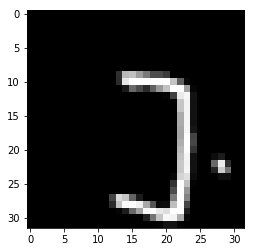

In [5]:
img = imagify(data.values[10], getimage=True)

In [6]:
# applying threshold to images
th1,img1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

127.0


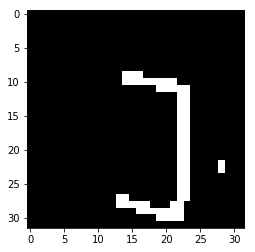

In [7]:
print(th1)
showimage(img1)

In [8]:
th2,img2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

106.0


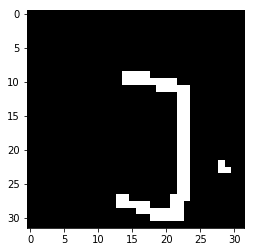

In [9]:
print(th2)
showimage(img2)

In [10]:
blur = cv2.GaussianBlur(img,(5,5),0)
th3,img3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

60.0


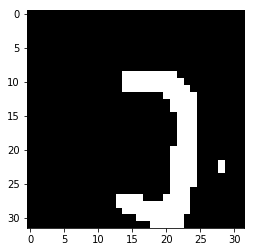

In [11]:
print(th3)
showimage(img3)

In [12]:
# finding threshold using otsu algorithm
THRESH_BINARY = cv2.THRESH_BINARY
THRESH_BINARY_AND_THRESH_OTSU = cv2.THRESH_BINARY+cv2.THRESH_OTSU

In [13]:

def apply_thresholding(df, cap=0, thres=THRESH_BINARY_AND_THRESH_OTSU):
    if thres == None:
        return df
    
    values = df.values
    thres_values = []
    thresholding_started = False
    for value in values:
        img = imagify(value, getimage=True, showimage=False)
        th_,img = cv2.threshold(img,cap,255,thres)
        img = [img.flatten()]
        if thresholding_started:
            thres_values = np.concatenate((thres_values, img), axis=0)
        else:
            thres_values = img
            thresholding_started = True
            
    thres_df = pd.DataFrame(thres_values, columns=df.columns)
    return thres_df

In [14]:
datacopy = data.copy()
data = apply_thresholding(data, thres=THRESH_BINARY_AND_THRESH_OTSU)
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.896,0.897,0.898,0.899,0.900,0.901,0.902,0.903,0.904,0.905
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
training_features = data.copy()

In [16]:
# handling missing data
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
imputer.fit(training_features)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [17]:
# standardizing data
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scalar.fit(training_features)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
training_features = imputer.transform(training_features)
training_features = scalar.transform(training_features)

In [19]:
data_labels = load_data(TRAINING_LABELS_FILE)
training_labels = data_labels.values.flatten()

In [20]:
test_data = load_data(TESTING_FEATURES_FILE)
test_data = apply_thresholding(test_data, thres=THRESH_BINARY_AND_THRESH_OTSU)
testing_features = test_data.copy()
testing_features = imputer.transform(testing_features)
testing_features = scalar.transform(testing_features)

In [21]:
test_data_labels = load_data(TESTING_LABELS_FILE)
testing_labels = test_data_labels.values.flatten()

In [22]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

forest_clf = RandomForestClassifier()
print("Cross Val Scores on training set\n", cross_val_score(clone(forest_clf), training_features, training_labels, cv=3, scoring="accuracy"))

forest_clf.fit(training_features, training_labels)
print("\n\nAccuracy on testing data set\n", sum(testing_labels == forest_clf.predict(testing_features)) / len(testing_labels))

Cross Val Scores on training set
 [0.30133929 0.30424107 0.32239339]


Accuracy on testing data set
 0.40815718963977377


In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve

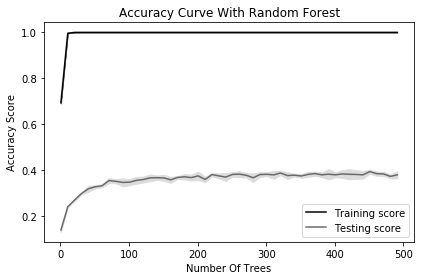

In [24]:
# Create range of values for parameter
param_range = np.arange(1, 500, 10)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(), 
                                             testing_features, 
                                             testing_labels, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Testing score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Accuracy Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()